# Notebook 1a: Data Builder

This notebook builds two datasets: one for Florida to be used for training and testing and a second dataset for all US counties on which the best ML model will be used to predict the variable of interest. To construct those two sets, we employed the following sources:

1. Johns Hopkins University.
2. Various sources that report health capacity indicators.
3. The New York Times.
4. Mobility data from the Descartes Project.
5. Cases data disaggregated by race and ethnicity from Florida's Heath Department.

From those sources, we assembled and constructed the following battery of features/predictors/variables that includes:

- **Mobility**: m50, m50_index.
- **Health capacity and pre-existing health conditions**: Active Physicians per 100000 Population 2018 (AAMC), ICU Beds, Average Daily PM2.5, Premature Death, Cardiovascular Deaths Per 100K.
- **Demographic and Socioeconomic**: % Severe Housing Problems, Density per square mile of land area - Population, Density per square mile of land area - Housing units, Median_Household_Income_2018, Percent_White, Percent_Black, Percent_NativeAmerican, Percent_Asian, Percent_NativeHawaiianPI, Percent_TwoPlusRaces, Percent_Hispanic, Age_0_14, Age_15_24, Age_25_44, Age_45_64, Age_65plus, C_Female, C_Male,
- **Covid related data**: cases, deaths, Subgroup_Case_Rate_Black, Subgroup_Case_Rate_White, Subgroup_Case_Rate_Hispanic, Subgroup_Case_Rate_AsianNA_NH_PI_TwoPlus.
- Date and Day_of_Week


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
import seaborn as sns 
from pandas.plotting import register_matplotlib_converters


1.0 Data Sources
==============


In [2]:
# data_sources
county_summaries = pd.read_csv("https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv")
all_county_health = pd.read_csv('CountyHealth.csv')
cardio_data = pd.read_csv('All counties cardio.csv')
iv_dates = pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/interventions.csv')
ny_times_county = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
mobility_df = pd.read_csv("https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv", dtype={'fips': str})
mobility_cases = pd.read_csv('fl_mobility_and_cases.csv')

In [3]:
pd.options.display.max_seq_items = 2000

2.0 Cleaning and Preparing Data
=======================


2.1 County Demographic Data
--------------------------------

In [4]:
#restricting county demographic dataframe to columns of interest
cols_to_keep = ['FIPS', 'State', 'Area_Name', 'Rural-urban_Continuum Code_2013',"POP_ESTIMATE_2018", 
                'Urban_Influence_Code_2013', 'Mar Temp AVG / F', 'Mar Temp Min / F', 
                'Mar Temp Max / F', 'Apr Temp AVG / F', 'Apr Temp Min / F', 'Apr Temp Max / F',
                "Total_Male", "Total_Female", "WA_MALE", "WA_FEMALE", "BA_MALE", "BA_FEMALE", "IA_MALE", "IA_FEMALE",
                "AA_MALE", "AA_FEMALE", "NA_MALE", "NA_FEMALE", "TOM_MALE", "TOM_FEMALE", "H_MALE", "H_FEMALE",
                "Total_age0to17", "Total_age18to64", "Total_age65plus",
                "Total households", "Percent of adults with less than a high school diploma 2014-18",
                "Percent of adults with a high school diploma only 2014-18",
                "Percent of adults completing some college or associate's degree 2014-18",
                "Percent of adults with a bachelor's degree or higher 2014-18", "Employed_2018",
                "Unemployment_rate_2018", "Median_Household_Income_2018", 
                "Med_HH_Income_Percent_of_State_Total_2018",
                "Density per square mile of land area - Population", 
                "Density per square mile of land area - Housing units",
                "Active Physicians per 100000 Population 2018 (AAMC)", 
                "All Specialties (AAMC)",
                "ICU Beds", "transit_scores - population weighted averages aggregated from town/city level to county",
                "Total households", "Total households!!Family households (families)", 
                "Total households!!Nonfamily households"]

feature_df = county_summaries[cols_to_keep]

In [5]:
#loading in county health indicators 

all_county_keep_cols = ['FIPS', 'State', 'County', 'Premature Death - Years of Potential Life Lost Rate', 
                        '% Adults with Obesity', 'Average Daily PM2.5', '% Severe Housing Problems']
all_county_health = all_county_health[all_county_keep_cols].dropna()
all_county_health['County'] = all_county_health['County'].astype(str) + ' County'
all_county_health = all_county_health.rename(columns={'County': 'Area_Name', 
                                                      'Premature Death - Years of Potential Life Lost Rate': 'Premature Death'})

In [6]:
us_state_abbrev = {
'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}
all_county_health['State'] = all_county_health['State'].map(us_state_abbrev).fillna(all_county_health['State'])


2.2 Cardiovascular Health Data
---------------------------------

In [7]:
cardio_data['Area_Name'] = cardio_data['Area_Name'].astype(str) + ' County'
cardio_data = cardio_data[['Area_Name', 'State', 'Cardiovascular Deaths Per 100K']]


2.3 Stay-At-Home Government Intervention Dates Data
-------------------------------------------------------------


In [8]:
iv_cols = ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in']

for col in iv_cols:
    iv_dates.loc[:, col] = iv_dates.loc[:, col].astype("Int64")
    iv_dates.loc[:, col] = iv_dates.loc[:, col][iv_dates.loc[:, col].notnull()].apply(datetime.date.fromordinal)
    iv_dates.loc[:, col] = pd.to_datetime(iv_dates[col], infer_datetime_format=True)

iv_dates = iv_dates[['FIPS'] + iv_cols]


2.4 NY Times County Level Data
----------------------------------


In [9]:
ny_times_county[ny_times_county['state'] == 'Florida'].groupby(['county'])['date'].count()
ny_times_county.loc[:, 'fips'] = ny_times_county.loc[:, 'fips'].fillna(0)
ny_times_county.loc[:, 'FIPS'] = ny_times_county.loc[:, 'fips'].astype(int)
ny_times_county['Date'] = pd.to_datetime(ny_times_county['date'], infer_datetime_format=True).dt.date
ny_times_county['Date'] = pd.to_datetime(ny_times_county['Date'])


2.5 Mobility Data
----------------


In [10]:
mobility_df.dropna(subset=['fips'], inplace=True)
mobility_df['Date'] = pd.to_datetime(mobility_df['date'], infer_datetime_format=True).dt.date
mobility_df['Date'] = pd.to_datetime(mobility_df['Date'])

mobility_df['FIPS'] = mobility_df['fips'].astype('int64')

2.6 Florida-Specific Mobility Cases Data
--------------------------------------------

In [11]:
mobility_cases.drop(columns=['samples', 'm50', 'm50_index'], inplace=True)
mobility_cases['Date'] = pd.to_datetime(mobility_cases['date_merge'], infer_datetime_format=True).dt.date
mobility_cases['Date'] = pd.to_datetime(mobility_cases['Date'])
mobility_cases.rename(columns={'fips': 'FIPS'}, inplace=True)


3.0 Merging Data Sets
===============


In [12]:
final_health_df = all_county_health.merge(cardio_data, how='inner')
county_level_df = feature_df.merge(final_health_df, how='left')
county_level_df = county_level_df.merge(iv_dates, on='FIPS', how='left')
ny_mobility = ny_times_county.merge(mobility_df, on=['Date', 'FIPS'], how='left')


In [13]:
pd.set_option('display.max_rows', None)


4.0 Generating Features
================


In [14]:
#Creating population percentages 

county_level_df.loc[:,'Percent_White'] = ((county_level_df['WA_MALE']+county_level_df['WA_FEMALE']) /(county_level_df['Total_Male'] + county_level_df['Total_Female']))*100
county_level_df.loc[:,'Percent_Black'] = ((county_level_df['BA_MALE']+county_level_df['BA_FEMALE']) /(county_level_df['Total_Male'] + county_level_df['Total_Female']))*100
county_level_df.loc[:,'Percent_NativeAmerican'] = ((county_level_df['IA_MALE']+county_level_df['IA_FEMALE']) /(county_level_df['Total_Male'] + county_level_df['Total_Female']))*100
county_level_df.loc[:,'Percent_Asian'] = ((county_level_df['AA_MALE']+county_level_df['AA_FEMALE']) /(county_level_df['Total_Male'] + county_level_df['Total_Female']))*100
county_level_df.loc[:,'Percent_NativeHawaiianPI'] = ((county_level_df['NA_MALE']+county_level_df['NA_FEMALE']) /(county_level_df['Total_Male'] + county_level_df['Total_Female']))*100
county_level_df.loc[:,'Percent_TwoPlusRaces'] = ((county_level_df['TOM_MALE']+county_level_df['TOM_FEMALE']) /(county_level_df['Total_Male'] + county_level_df['Total_Female']))*100
county_level_df.loc[:,'Percent_Hispanic'] = ((county_level_df['H_MALE']+county_level_df['H_FEMALE']) /(county_level_df['Total_Male'] + county_level_df['Total_Female']))*100

In [15]:
final_counties = ny_mobility.merge(county_level_df, on='FIPS', how='left')

In [16]:
# Creating Florida Counties Data Sets

florida_df = final_counties[final_counties['State'] == 'FL']
florida_df = florida_df[florida_df['FIPS'] != 12000]
florida_2 = mobility_cases.merge(florida_df, on=['Date','FIPS'], how='left')

In [17]:
#Creating population normalized case and death rates for use in visual analysis 

groupby_cols = ['Area_Name',
                'Density per square mile of land area - Population', 
                'Density per square mile of land area - Housing units', '% Severe Housing Problems', 'Median_Household_Income_2018',
                'Premature Death', 'Cardiovascular Deaths Per 100K', 'POP_ESTIMATE_2018', 
                'Average Daily PM2.5','Percent of adults with less than a high school diploma 2014-18',
                'Percent of adults with a high school diploma only 2014-18',
                "Percent of adults completing some college or associate's degree 2014-18",
                "Percent of adults with a bachelor's degree or higher 2014-18",
                'Employed_2018', 'Unemployment_rate_2018',
                'Percent_White','Percent_Black', 'Percent_NativeAmerican', 'Percent_Asian',
                'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic']
                            

per_county_demo = florida_2.groupby(groupby_cols).agg({'T_Total_Res': 'max', 
                                                       'T_negative': 'max', 
                                                       'T_positive': 'max',
                                                       'cases': 'max', 
                                                       'deaths': 'max', 
                                                       'm50': 'mean', 
                                                       'm50_index': 'mean'}).reset_index()

per_county_demo['county_deaths_100000'] = (per_county_demo['deaths'] / florida_2['POP_ESTIMATE_2018']) * 100000
per_county_demo['county_cases_100000'] = (per_county_demo['cases'] / florida_2['POP_ESTIMATE_2018']) * 100000


5.0 Data Exploration
===============


5.1 Visualizations
---------------------

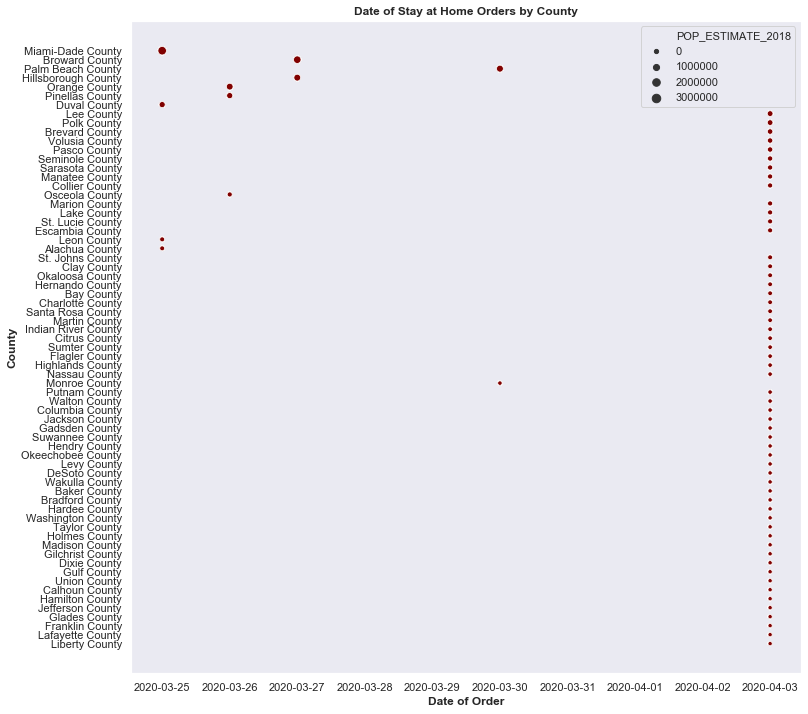

In [18]:
#plotting when counties instituted state at home orders (most were likely mandated by state) 

register_matplotlib_converters()

sns.set(rc={'figure.figsize':(12, 12)})
sns.set_style("dark")
sorted_pop = florida_df.sort_values(by='POP_ESTIMATE_2018')
intervention = sns.scatterplot(x='stay at home', y='Area_Name', data = sorted_pop, 
                               size = "POP_ESTIMATE_2018", color="maroon")
intervention.set_title("Date of Stay at Home Orders by County", weight='bold') 
intervention.set_xlabel("Date of Order", weight='bold')
intervention.set_ylabel("County", weight='bold');

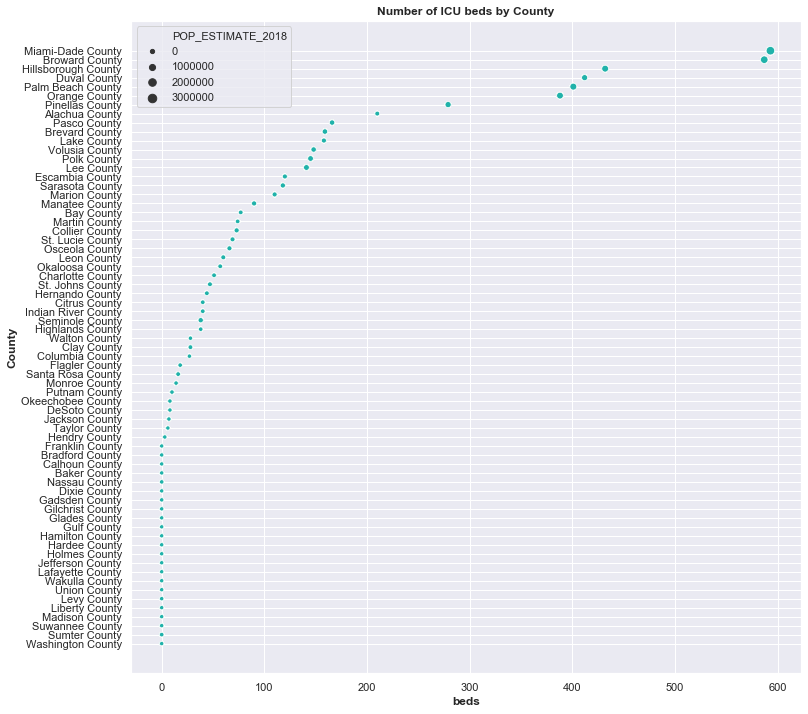

In [19]:
sns.set(rc={'figure.figsize':(12, 12)})

sorted_beds = florida_df.sort_values(by='ICU Beds')
beds = sns.scatterplot(x='ICU Beds', y='Area_Name', data = sorted_beds, size="POP_ESTIMATE_2018", color='lightseagreen')
beds.set_title("Number of ICU beds by County", weight='bold') 
beds.set_xlabel("beds", weight='bold')
beds.set_ylabel("County", weight='bold');

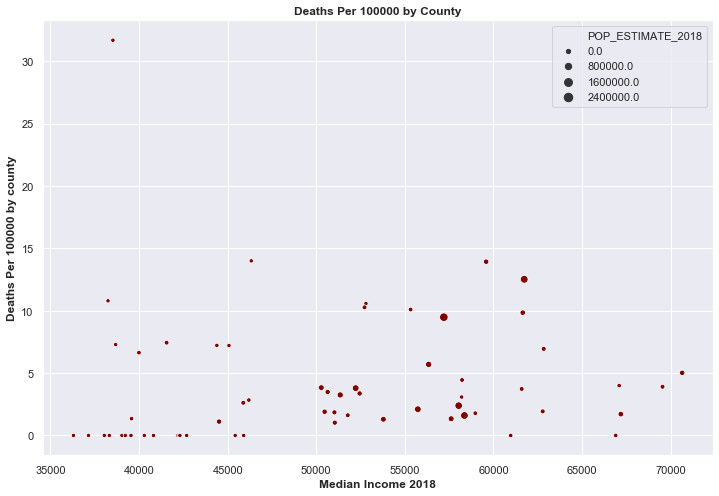

In [20]:
sns.set(rc={'figure.figsize':(12, 8)})

#looking at deaths per 100000 by county median household income 
deaths_100k = sns.scatterplot(x='Median_Household_Income_2018', y='county_deaths_100000', 
                              data = per_county_demo, size='POP_ESTIMATE_2018', 
                              color='maroon')
deaths_100k.set_title("Deaths Per 100000 by County", weight='bold') 
deaths_100k.set_xlabel("Median Income 2018", weight='bold')
deaths_100k.set_ylabel("Deaths Per 100000 by county", weight='bold');

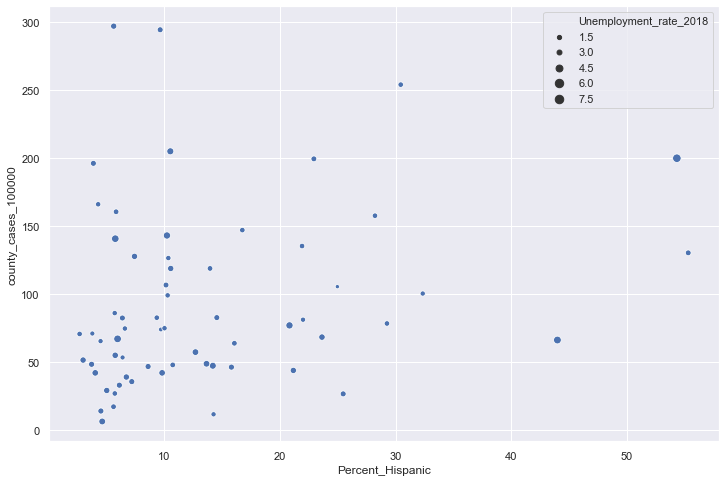

In [21]:
#looking at the case rate by Percent Hispanic by county 
cases_100k = sns.scatterplot(x='Percent_Hispanic', y='county_cases_100000', 
                              data = per_county_demo, size='Unemployment_rate_2018')


5.2 Data Exploration
=============


In [22]:
#county demographic descriptions -- education  

florida_df[["Percent of adults with a high school diploma only 2014-18",
              "Percent of adults completing some college or associate's degree 2014-18",
              "Percent of adults with a bachelor's degree or higher 2014-18"]].describe()

,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18
count,5288.000000,5288.000000,5288.000000
mean,33.253782,29.771539,22.865185
std,6.666829,4.122874,9.672190
min,19.100000,17.400000,7.400000
25%,27.700000,28.000000,13.800000
50%,33.100000,29.800000,22.800000
75%,38.300000,32.500000,29.300000
max,47.900000,37.100000,45.700000


In [23]:
#demographic descriptions --- economic 

florida_df[["Employed_2018",
                "Unemployment_rate_2018", "Median_Household_Income_2018",
                "Median_Household_Income_2018", 
                "Med_HH_Income_Percent_of_State_Total_2018"]].describe()

,Employed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
count,5.288000e+03,5288.000000,5288.000000,5288.000000,5288.000000
mean,1.637979e+05,3.766471,51507.236762,51507.236762,92.915450
std,2.572975e+05,0.607600,10115.344131,10115.344131,18.250612
min,2.543000e+03,2.600000,36299.000000,36299.000000,65.500000
25%,1.430700e+04,3.400000,42258.000000,42258.000000,76.200000
50%,6.728000e+04,3.700000,51777.000000,51777.000000,93.400000
75%,1.717520e+05,4.000000,58228.000000,58228.000000,105.000000
max,1.330023e+06,6.100000,81925.000000,81925.000000,147.800000


In [24]:
# Florida Demographic and Health Data
florida_2.sample(5)

,AgeRange,Age_0_4,Age_0_9,Age_10_19,Age_15_24,Age_20_29,Age_25_34,Age_30_39,Age_35_44,Age_40_49,...,>500 gatherings,public schools,restaurant dine-in,Percent_White,Percent_Black,Percent_NativeAmerican,Percent_Asian,Percent_NativeHawaiianPI,Percent_TwoPlusRaces,Percent_Hispanic
1189,NaN,3.0,NaN,NaN,14.0,NaN,34.0,NaN,29.0,NaN,...,2020-03-17,2020-03-16,2020-03-20,83.164413,13.101876,0.739349,0.739349,0.092419,2.162595,3.767598
1581,NaN,3.0,NaN,NaN,16.0,NaN,35.0,NaN,47.0,NaN,...,2020-03-17,2020-03-16,2020-03-20,83.949780,10.739111,0.399761,2.603800,0.091017,2.216531,10.542800
1053,NaN,63.0,NaN,NaN,245.0,NaN,461.0,NaN,557.0,NaN,...,2020-03-17,2020-03-16,2020-03-20,87.930619,6.466097,0.477735,2.702407,0.104145,2.318996,15.790820
1936,NaN,3.0,NaN,NaN,2.0,NaN,6.0,NaN,7.0,NaN,...,2020-03-17,2020-03-16,2020-03-20,74.283802,22.650602,0.528782,0.742972,0.040161,1.753681,5.709505
2181,NaN,5.0,NaN,NaN,27.0,NaN,40.0,NaN,42.0,NaN,...,2020-03-17,2020-03-16,2020-03-20,91.526957,4.776222,0.319180,1.781973,0.061868,1.533800,9.338251


In [25]:
per_county_demo['Area_Name'].nunique()

63

6.0 Finalizing Florida Dataframe
=================================

In [26]:
keep_cols = ['FIPS', 'Area_Name', 
             'Date', 
             'm50', 'm50_index',
             'POP_ESTIMATE_2018',
             'Urban_Influence_Code_2013', 
             'Mar Temp AVG / F', 'Apr Temp AVG / F',
             'Total_age0to17', 
             'Total_age18to64', 
             'Total_age65plus', 
             'Med_HH_Income_Percent_of_State_Total_2018', 
             '% Adults with Obesity', 
             'transit_scores - population weighted averages aggregated from town/city level to county', 
             'Percent of adults with less than a high school diploma 2014-18',
             'Employed_2018', 'Unemployment_rate_2018',
             'Active Physicians per 100000 Population 2018 (AAMC)', 
             'All Specialties (AAMC)',
             'ICU Beds',
             'T_negative', 'T_positive','T_total', 'TPending',
             'Average Daily PM2.5', '% Severe Housing Problems',
             'Premature Death', 'Cardiovascular Deaths Per 100K',
             'Density per square mile of land area - Population', 'Density per square mile of land area - Housing units',
             'Median_Household_Income_2018', 'Total_Male', 'Total_Female', 'WA_MALE',
             'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE',
             'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'H_MALE', 'H_FEMALE',
             'Percent_White', 'Percent_Black', 'Percent_NativeAmerican', 'Percent_Asian', 'Percent_NativeHawaiianPI',
             'Percent_TwoPlusRaces', 'Percent_Hispanic',
             'restaurant dine-in', 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
             'Age_0_4', 'Age_0_9', 'Age_10_19', 'Age_15_24', 'Age_20_29', 'Age_25_34',
             'Age_30_39', 'Age_35_44', 'Age_40_49', 'Age_45_54', 'Age_50_59',
             'Age_55_64', 'Age_5_14', 'Age_60_69', 'Age_65_74', 'Age_70_79',
             'Age_75_84', 'Age_80plus', 'Age_85plus', 'Age_Unkn', 'Age_Unknown',
             'AverageAge', 'COUNTYN', 'C_AgeAvrg', 'C_AgeMedian', 'C_AgeRange',
             'C_Age_0_4', 'C_Age_0_9', 'C_Age_10_19', 'C_Age_15_24', 'C_Age_20_29',
             'C_Age_25_34', 'C_Age_30_39', 'C_Age_35_44', 'C_Age_40_49',
             'C_Age_45_54', 'C_Age_50_59', 'C_Age_55_64', 'C_Age_5_14',
             'C_Age_60_69', 'C_Age_65_74', 'C_Age_70_79', 'C_Age_75_84',
             'C_Age_80plus', 'C_Age_85plus',
             'C_Female', 'C_Male', 'C_HispanicYES', 'C_RaceBlack',
             'C_RaceWhite', 'C_RaceOther', 'C_HospYes_NonRes', 'C_HospYes_Res', 'C_Hosp_No', 
             'C_Hosp_Nodata', 'C_Hosp_Yes', 'CasesAll', 'cases', 'deaths']

In [27]:
final_df = florida_2[keep_cols]
final_df.loc[:, 'Date'] = pd.to_datetime(final_df.loc[:, 'Date'], infer_datetime_format=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


6.1 Checking Florida Dataframe for % of NaNs
----------------------------

In [28]:
counter = 0 
for i, column in enumerate(final_df.columns):
    nas = final_df[column].isna().sum()
    if nas > 0:
        print('''{} has {} missing values: {:0.2f} percent of all'''.format(column, nas, 100*nas/len(final_df))
        )
        counter+= 1
print("percent of columns with missing values:", counter/len(final_df.columns))

Area_Name has 285 missing values: 10.67 percent of all
m50 has 285 missing values: 10.67 percent of all
m50_index has 285 missing values: 10.67 percent of all
POP_ESTIMATE_2018 has 285 missing values: 10.67 percent of all
Urban_Influence_Code_2013 has 285 missing values: 10.67 percent of all
Mar Temp AVG / F has 285 missing values: 10.67 percent of all
Apr Temp AVG / F has 285 missing values: 10.67 percent of all
Total_age0to17 has 285 missing values: 10.67 percent of all
Total_age18to64 has 285 missing values: 10.67 percent of all
Total_age65plus has 285 missing values: 10.67 percent of all
Med_HH_Income_Percent_of_State_Total_2018 has 285 missing values: 10.67 percent of all
% Adults with Obesity has 285 missing values: 10.67 percent of all
transit_scores - population weighted averages aggregated from town/city level to county has 285 missing values: 10.67 percent of all
Percent of adults with less than a high school diploma 2014-18 has 285 missing values: 10.67 percent of all
Employ

In [29]:
#checking to see which dates have nulls for our proto-target column 
final_df.groupby('Date').agg({'C_RaceBlack': lambda x: x.isnull().sum()})

,C_RaceBlack
Date,
2020-03-19,53.0
2020-03-20,55.0
2020-03-21,61.0
2020-03-22,62.0
2020-03-23,62.0
2020-03-24,63.0
2020-03-25,62.0
2020-03-26,63.0
2020-03-27,62.0


6.2 Generating Features for Florida Dataset
---------------------------

In [30]:
#Creating case percentages by population 
#C_HispanicYES	C_RaceBlack	C_RaceWhite	C_RaceOther
final_df.loc[:,'Percent_Black_All_Cases'] = (final_df['C_RaceBlack'] / final_df['CasesAll'])*100
final_df.loc[:,'Subgroup_Case_Rate_Black']= (final_df['C_RaceBlack'] / (final_df['BA_MALE'] + final_df['BA_FEMALE']))*100
final_df.loc[:,'Percent_White_All_Cases'] = (final_df['C_RaceWhite'] / final_df['CasesAll'])*100
final_df.loc[:,'Subgroup_Case_Rate_White']= (final_df['C_RaceWhite'] / (final_df['WA_MALE'] + final_df['WA_FEMALE']))*100
final_df.loc[:,'Percent_Hispanic_All_Cases']= (final_df['C_HispanicYES'] / final_df['CasesAll'])*100
final_df.loc[:,'Subgroup_Case_Rate_Hispanic']= (final_df['C_HispanicYES'] / (final_df['H_MALE'] + final_df['H_FEMALE']))*100
final_df.loc[:,'Percent_AsianNA_NH_PI_TwoPlus_All_Cases']= (final_df['C_RaceOther'] / final_df['CasesAll'])*100
final_df.loc[:,'Subgroup_Case_Rate_AsianNA_NH_PI_TwoPlus']= (final_df['C_RaceOther'] /(final_df['IA_MALE'] + final_df['IA_FEMALE'] + final_df['AA_MALE'] 
                                                                                       + final_df['AA_FEMALE'] + final_df['NA_MALE'] +final_df['NA_FEMALE'] 
                                                                                       + final_df['TOM_MALE']+final_df['TOM_FEMALE']))*100

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [31]:
#creating age bins for county demographic data
final_df.loc[:,'Age_0_14'] = final_df['Age_0_4'] + final_df['Age_5_14']
final_df.loc[:,'Age_15_24'] = final_df['Age_15_24']
final_df.loc[:,'Age_25_44'] = final_df['Age_25_34'] + final_df['Age_35_44']
final_df.loc[:,'Age_45_64'] = final_df['Age_45_54'] + final_df['Age_55_64']
final_df.loc[:,'Age_65plus'] = final_df['Age_65_74'] + final_df['Age_75_84'] + final_df['Age_85plus']


In [32]:
#creating age bins for florida county case data 
final_df.loc[:,'Cases_Age_0_14'] = final_df['C_Age_0_4'] + final_df['C_Age_5_14']
final_df.loc[:,'Cases_Age_15_24'] = final_df['C_Age_15_24']
final_df.loc[:,'Cases_Age_25_44'] = final_df['C_Age_25_34'] + final_df['C_Age_35_44']
final_df.loc[:,'Cases_Age_45_64'] = final_df['C_Age_45_54'] + final_df['C_Age_55_64']
final_df.loc[:,'Cases_Age_65plus'] = final_df['C_Age_65_74'] + final_df['C_Age_75_84'] + final_df['C_Age_85plus']

In [33]:
#convert datetime of interventions to boolean
final_df['dine_in_bool'] = final_df['restaurant dine-in'] <= final_df['Date']
final_df['stay at home_bool'] = final_df['stay at home'] <= final_df['Date']
final_df['>50 gatherings_bool'] = final_df['>50 gatherings']<= final_df['Date']
final_df['>500 gatherings_bool'] = final_df['>500 gatherings'] <= final_df['Date']
final_df['public_schools_bool'] = final_df['public schools'] <= final_df['Date']

final_df['Subgroup_Case_Rate_Black'].sample(10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

2571         NaN
443     0.036967
1226         NaN
2494         NaN
2235         NaN
1847         NaN
1231         NaN
1745         NaN
1057    0.138074
2668         NaN
Name: Subgroup_Case_Rate_Black, dtype: float64

6.3 Condensing and Further Cleaning of Florida Dataset
----------------------

In [34]:
new_keep_cols = [
        'Date',  
        'm50', 'm50_index', 
        'POP_ESTIMATE_2018',
        'Urban_Influence_Code_2013', 
        'Mar Temp AVG / F', 'Apr Temp AVG / F',
        'Total_age0to17', 
        'Total_age18to64', 
        'Total_age65plus',
        'Percent of adults with less than a high school diploma 2014-18',
        'Employed_2018', 'Unemployment_rate_2018',
        'Median_Household_Income_2018',
        'Med_HH_Income_Percent_of_State_Total_2018',
        'Density per square mile of land area - Population',
        'Density per square mile of land area - Housing units',
        'Active Physicians per 100000 Population 2018 (AAMC)',
        'All Specialties (AAMC)', 
        'ICU Beds',
        'transit_scores - population weighted averages aggregated from town/city level to county',
        'Premature Death',
        '% Adults with Obesity', 
        'Average Daily PM2.5',
        '% Severe Housing Problems', 
        'Cardiovascular Deaths Per 100K',
        'stay at home_bool', '>50 gatherings_bool', '>500 gatherings_bool', 
        'public_schools_bool',
        'dine_in_bool', 
        'Percent_White', 'Percent_Black',
        'Percent_NativeAmerican', 'Percent_Asian', 
        'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 
        'Percent_Hispanic', 
        'Age_0_14', 'Age_15_24', 'Age_25_44', 'Age_45_64', 'Age_65plus',
        'C_Female', 'C_Male', 'Subgroup_Case_Rate_Black', 'Subgroup_Case_Rate_White',
        'Subgroup_Case_Rate_Hispanic', 'Subgroup_Case_Rate_AsianNA_NH_PI_TwoPlus', 
        'T_negative', 'T_positive', 'T_total', 'cases', 'deaths']

In [35]:
ml_df = final_df[new_keep_cols]
ml_df.head(5)

,Date,m50,m50_index,POP_ESTIMATE_2018,Urban_Influence_Code_2013,Mar Temp AVG / F,Apr Temp AVG / F,Total_age0to17,Total_age18to64,Total_age65plus,...,C_Male,Subgroup_Case_Rate_Black,Subgroup_Case_Rate_White,Subgroup_Case_Rate_Hispanic,Subgroup_Case_Rate_AsianNA_NH_PI_TwoPlus,T_negative,T_positive,T_total,cases,deaths
0,2020-04-30,4.512,58.0,269956.0,2.0,63.6,69.3,48541.0,183579.0,37836.0,...,103.0,0.149348,0.056739,0.064886,0.077528,6627.0,267.0,6901.0,267.0,5.0
1,2020-04-30,8.219,58.0,28355.0,1.0,61.6,68.0,6715.0,17625.0,4015.0,...,7.0,0.050352,0.072239,0.000000,0.117647,363.0,20.0,383.0,20.0,3.0
2,2020-04-30,5.601,70.0,185287.0,2.0,61.8,67.2,39761.0,113848.0,31678.0,...,44.0,0.036967,0.035671,0.120715,0.032621,1474.0,72.0,1548.0,72.0,3.0
3,2020-04-30,8.944,78.0,27732.0,4.0,63.0,69.1,5436.0,17361.0,4935.0,...,8.0,0.053947,0.202049,0.000000,0.000000,717.0,46.0,765.0,46.0,2.0
4,2020-04-30,3.192,41.0,596849.0,2.0,67.2,72.8,108913.0,346591.0,141345.0,...,135.0,0.073419,0.040254,0.062538,0.036121,8082.0,285.0,8370.0,285.0,8.0


In [36]:
#condensing florida df to drop rows with missing target values 
start_dt = '2020-04-13'
end_dt = '2020-04-30'
dt_filter = (ml_df['Date'] >= start_dt) & (ml_df['Date'] <= end_dt)
condensed_ml_df = ml_df.loc[dt_filter]

In [37]:
#checking columns with na values in condensed framework 
counter = 0 
potential_cols_to_drop = [] 
for i, column in enumerate(condensed_ml_df.columns):
    nas = condensed_ml_df[column].isna().sum()
    if nas > 0:
        print('''{} has {} missing values: {:0.2f} percent of all'''.format(column, nas, 100*nas/len(condensed_ml_df))
        )
        counter+= 1
        potential_cols_to_drop.append(column)
print("percent of columns with missing values:", counter/len(condensed_ml_df.columns))

percent of columns with missing values: 0.0


In [38]:
#drop columns with high na values from dataset
condensed_ml_df = condensed_ml_df.drop(columns=potential_cols_to_drop) 
condensed_ml_df.shape

(1068, 54)

In [39]:
#Sort by date ascending and reset index for use in time series split 
condensed_ml_df.sort_values(by=['Date'], inplace=True)
condensed_ml_df.reset_index(drop=True, inplace=True)
condensed_ml_df.head(3)

,Date,m50,m50_index,POP_ESTIMATE_2018,Urban_Influence_Code_2013,Mar Temp AVG / F,Apr Temp AVG / F,Total_age0to17,Total_age18to64,Total_age65plus,...,C_Male,Subgroup_Case_Rate_Black,Subgroup_Case_Rate_White,Subgroup_Case_Rate_Hispanic,Subgroup_Case_Rate_AsianNA_NH_PI_TwoPlus,T_negative,T_positive,T_total,cases,deaths
0,2020-04-13,8.413,48.0,24880.0,6.0,60.6,66.4,4955.0,15562.0,4363.0,...,3.0,0.000000,0.019986,0.000000,0.000000,103.0,4.0,112.0,4.0,0.0
1,2020-04-13,8.631,45.0,19477.0,6.0,59.7,65.9,3938.0,11668.0,3871.0,...,2.0,0.000000,0.011539,0.000000,0.000000,85.0,2.0,92.0,2.0,0.0
2,2020-04-13,0.715,8.0,1436888.0,1.0,68.0,73.6,323986.0,907587.0,205315.0,...,386.0,0.047582,0.035041,0.051653,0.146698,11577.0,790.0,12398.0,813.0,16.0


In [40]:
#convert datetime into a day of week feature for use in model 
condensed_ml_df['Day_of_Week'] = condensed_ml_df['Date'].dt.weekday

In [41]:
condensed_ml_df.columns

Index(['Date', 'm50', 'm50_index', 'POP_ESTIMATE_2018',
       'Urban_Influence_Code_2013', 'Mar Temp AVG / F', 'Apr Temp AVG / F',
       'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
       'Percent of adults with less than a high school diploma 2014-18',
       'Employed_2018', 'Unemployment_rate_2018',
       'Median_Household_Income_2018',
       'Med_HH_Income_Percent_of_State_Total_2018',
       'Density per square mile of land area - Population',
       'Density per square mile of land area - Housing units',
       'Active Physicians per 100000 Population 2018 (AAMC)',
       'All Specialties (AAMC)', 'ICU Beds',
       'transit_scores - population weighted averages aggregated from town/city level to county',
       'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
       '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
       'stay at home_bool', '>50 gatherings_bool', '>500 gatherings_bool',
       'public_schools_bool', 'dine_in_bool'

In [42]:
condensed_ml_df.to_csv("final_fl_df.csv", index=False)

7.0 Creating the All US Counties Dataset to Deploy the Trained and Tested Model on It
=================================

In [43]:
final_counties.shape

(212606, 82)

In [44]:
final_counties

new_keep_cols = ['FIPS', 'state', 'Area_Name', 'Date', 
                'm50', 'm50_index', 
                'POP_ESTIMATE_2018',
                'Urban_Influence_Code_2013', 
                'Mar Temp AVG / F', 'Apr Temp AVG / F', 
                'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
                'Percent of adults with less than a high school diploma 2014-18',
                'Employed_2018', 'Unemployment_rate_2018',
                'Median_Household_Income_2018',
                'Med_HH_Income_Percent_of_State_Total_2018',
                'Density per square mile of land area - Population',
                'Density per square mile of land area - Housing units',
                'Active Physicians per 100000 Population 2018 (AAMC)',
                'All Specialties (AAMC)', 'ICU Beds',
                'transit_scores - population weighted averages aggregated from town/city level to county',
                'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
                '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
                'Percent_White', 'Percent_Black', 
                'Percent_NativeAmerican', 'Percent_Asian',
                'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic',
                'cases', 'deaths']

final_all_counties_df = final_counties[new_keep_cols]
final_all_counties_df.head(5)

,FIPS,state,Area_Name,Date,m50,m50_index,POP_ESTIMATE_2018,Urban_Influence_Code_2013,Mar Temp AVG / F,Apr Temp AVG / F,...,Cardiovascular Deaths Per 100K,Percent_White,Percent_Black,Percent_NativeAmerican,Percent_Asian,Percent_NativeHawaiianPI,Percent_TwoPlusRaces,Percent_Hispanic,cases,deaths
0,53061,Washington,Snohomish County,2020-01-21,NaN,NaN,814901,1.0,39.9,44.3,...,349.9,77.597524,3.673821,1.580192,11.637119,0.689409,4.821935,10.444091,1,0
1,53061,Washington,Snohomish County,2020-01-22,NaN,NaN,814901,1.0,39.9,44.3,...,349.9,77.597524,3.673821,1.580192,11.637119,0.689409,4.821935,10.444091,1,0
2,53061,Washington,Snohomish County,2020-01-23,NaN,NaN,814901,1.0,39.9,44.3,...,349.9,77.597524,3.673821,1.580192,11.637119,0.689409,4.821935,10.444091,1,0
3,17031,Illinois,Cook County,2020-01-24,NaN,NaN,5180493,1.0,34.1,49.2,...,434.3,65.457921,23.862015,0.738405,7.878613,0.074761,1.988286,25.538438,1,0
4,53061,Washington,Snohomish County,2020-01-24,NaN,NaN,814901,1.0,39.9,44.3,...,349.9,77.597524,3.673821,1.580192,11.637119,0.689409,4.821935,10.444091,1,0


In [45]:
#condensing all counties df to period of study
start_dt = '2020-04-13'
end_dt = '2020-04-30'
dt_filter = (final_all_counties_df['Date'] >= start_dt) & (final_all_counties_df['Date'] <= end_dt)
final_all_counties_df = final_all_counties_df.loc[dt_filter]

#checking columns with na values in condensed framework 
counter = 0 
potential_cols_to_drop = [] 
for i, column in enumerate(final_all_counties_df.columns):
    nas = final_all_counties_df[column].isna().sum()
    if nas > 0:
        print('''{} has {} missing values: {:0.2f} percent of all'''.format(column, nas, 100*nas/len(final_all_counties_df))
        )
        counter+= 1
        potential_cols_to_drop.append(column)
print("percent of columns with missing values:", counter/len(final_all_counties_df.columns))

m50 has 7460 missing values: 14.90 percent of all
m50_index has 7460 missing values: 14.90 percent of all
Urban_Influence_Code_2013 has 520 missing values: 1.04 percent of all
Mar Temp AVG / F has 610 missing values: 1.22 percent of all
Apr Temp AVG / F has 610 missing values: 1.22 percent of all
Med_HH_Income_Percent_of_State_Total_2018 has 520 missing values: 1.04 percent of all
Density per square mile of land area - Population has 18 missing values: 0.04 percent of all
Density per square mile of land area - Housing units has 18 missing values: 0.04 percent of all
Active Physicians per 100000 Population 2018 (AAMC) has 520 missing values: 1.04 percent of all
All Specialties (AAMC) has 520 missing values: 1.04 percent of all
ICU Beds has 520 missing values: 1.04 percent of all
transit_scores - population weighted averages aggregated from town/city level to county has 1768 missing values: 3.53 percent of all
Premature Death has 4809 missing values: 9.61 percent of all
% Adults with Obe

In [46]:
#drop columns with high na values from dataset

final_all_counties_df.shape

(50059, 38)

In [47]:
#Sort by date ascending and reset index for use in time series split 
final_all_counties_df.sort_values(by=['Date'], inplace=True)
final_all_counties_df.reset_index(drop=True, inplace=True)
final_all_counties_df.head(3)

,FIPS,state,Area_Name,Date,m50,m50_index,POP_ESTIMATE_2018,Urban_Influence_Code_2013,Mar Temp AVG / F,Apr Temp AVG / F,...,Cardiovascular Deaths Per 100K,Percent_White,Percent_Black,Percent_NativeAmerican,Percent_Asian,Percent_NativeHawaiianPI,Percent_TwoPlusRaces,Percent_Hispanic,cases,deaths
0,1001,Alabama,Autauga County,2020-04-13,6.356,43.0,55601,2.0,56.1,65.0,...,517.4,76.725239,19.630942,0.480207,1.224798,0.111509,1.827305,2.965774,19,1
1,39087,Ohio,Lawrence County,2020-04-13,2.571,32.0,59866,2.0,41.7,56.5,...,539.5,95.511643,2.161494,0.238867,0.471052,0.016704,1.600241,1.025624,17,0
2,39089,Ohio,Licking County,2020-04-13,1.547,14.0,175769,1.0,36.9,52.4,...,438.1,91.454693,4.070684,0.328841,1.855845,0.052341,2.237596,1.988405,86,3


In [48]:
#convert datetime into a day of week feature for use in model 
final_all_counties_df['Day_of_Week'] = final_all_counties_df['Date'].dt.weekday

In [49]:
final_all_counties_df.to_csv("final_all_counties_df.csv", index=False)